In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols:
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [2]:
cols
# The details of our "example" person

{'HINS1': 'HINS1_2.0',
 'HINS2': 'HINS2_2.0',
 'HINS4': 'HINS4_2.0',
 'CIT': 'CIT_1.0',
 'COW': 'COW_1.0',
 'SCHL': 'SCHL_16.0',
 'MAR': 'MAR_5.0',
 'SEX': 'SEX_1.0',
 'RAC1P': 'RAC1P_1.0',
 'ENG': 'ENG_1.0'}

### Reference Person Explanation
When encoding the discrete variables of our data. We chose the reference datapoint from Table: XX.
We chose to use this reference person as we assert this person is the "generic" american citizen in this case. <br>
| **Variable** | **Value** | **Reason** |
| --------- | -------- | --------- |
| HINS1 | 2 | As a rule, we assume that respondants don't have any form of insurance. |
| HINS2 | 2 | Same as above. |
| HINS4 | 2 | Same as above. | 
| CIT | 1 | We assume that respondants would be american-born. |
| COW | 1 | We find that working for a private for-profit company is the most "baseline" occupation. |
| SCHL | 16 | We set the reference as High school, since it fits nicely in the middle of the variable. | 
| MAR | 5 | Non-married as reference. Able to compare with the starting point in ones love life. |
| SEX | 1 | Male as reference. Slight majority in data. |
| ENG | 1 | Use very well english speaking as reference, since the country is english speaking natively.|




In [3]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.loc[X_test['SEX_2.0'] == True] 
    s1 = X_test.loc[X_test['SEX_2.0'] == False]

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)


    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [5]:
# Needed to make sure logisric regression converges
X_train['AGEP'] = MinMaxScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = MinMaxScaler().fit_transform(X_test[['AGEP']])

In [6]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = RandomForestClassifier(**rf_args)
p2 = lr_model

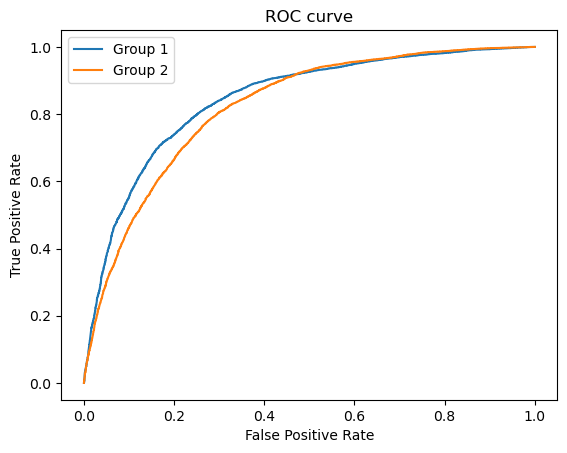

Optimal threshold for group 1:  0.5706189249350851
Optimal threshold for group 2:  0.47726061965611993
Accuracy for group 1:  0.7623781581882547
Accuracy for group 2:  0.7521067415730337
Selection rate for s1:  0.5265506037534552
Selection rate for s2:  0.5473206568712187
Statistical parity:  0.020770053117763476


In [7]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.4, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best
print("Optimal threshold for group 1: ", optimal_threshold1)
print("Optimal threshold for group 2: ", optimal_threshold2)

print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))

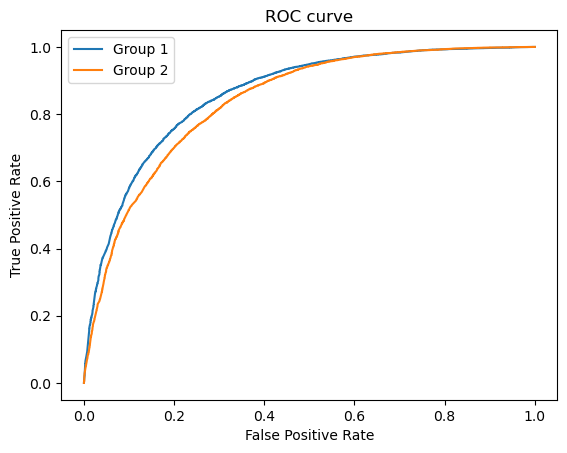

Optimal threshold for group 1:  0.5891784310297405
Optimal threshold for group 2:  0.5313066763335087
Accuracy for group 1:  0.7856069055816886
Accuracy for group 2:  0.7583729472774416
Selection rate for s1:  0.734154502691431
Selection rate for s2:  0.5689282627484875
Statistical parity:  0.1652262399429435


In [8]:
p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.4, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.66 # 0.66 best 
preds_s2 = scores_s2 > optimal_threshold2 # 0.4756088801681863 best
print("Optimal threshold for group 1: ", optimal_threshold1)
print("Optimal threshold for group 2: ", optimal_threshold2)

p1_done = evaluate_pipeline(p1, X_train, y_train, X_test, y_test, 0.401, optimal_threshold2)
print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

statistical_parity = np.sum(preds_s1)/len(s1) - np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(statistical_parity))

### Changes to be made to models
The accuracy of the classifier sits at 0.77 as of baseline test with the selected pipeline. Standard-scaling was used across all features, which may end up causing trouble. The model has a fairly high accuracy for a baseline classifier, with desirable f1-scores at [0.72, 0.81]. Since the outcome variable in this case is almost equally balanced at the chosen threshold, we need not to scale our model much with respect to the outcome variable. In this pipeline discrete variables are scaled, which changes the otherwise explainable binary variables, which hurts the explainability of the model. <br>
<br>
We would need to only scale the age column in the data to fix this explainability issue. Unless we had more continuous ways of representing the discrete variables in the data (such as language test scores for english proficiency, SAT scores for education etc.) we would not be able to quantify these columns in any meaningful fashion.

### What we did
In trying to improve the interpretability of our model, we limit the scaling to exclusively be applied to the "AGEP" column, seeing as it is the only continuous variable in the data. We also use the template's onehot-encodings applied to the discrete variables, with dropping the first value applied. This way we can compare each categorical variable to the baseline of the one which is dropped. <br>

Before making any changes to any of the models we find the following accuracies of the classifiers: 
<br>
(insert classification report for models)
<br>



## Task 3: Model agnostic explainations with SHAP

Here we use model agnostic explainations with SHAP to explain both of the models.

We first use a plot that takes all data rows to explain a bit generally the model overall.

Then we use take some specific rows of data in an attempt to explain more specific aspects of the models.

For features that are one-hot encoded we aggregate them.

In [9]:
# imports
import shap
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Rows chosen for comparison

In [10]:
specific_rows = [0, 1, 2, 3, 4] # for now just all rows used for debugging

In [156]:
X_train.iloc[[0]]

,AGEP,HINS1_1.0,HINS1_nan,HINS2_1.0,HINS2_nan,HINS4_1.0,HINS4_nan,CIT_2.0,CIT_3.0,CIT_4.0,...,RAC1P_5.0,RAC1P_6.0,RAC1P_7.0,RAC1P_8.0,RAC1P_9.0,RAC1P_nan,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
358945,0.376623,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True


## Generating the plots

In [12]:
X_train.isna().any(axis=1).sum()

0

In [13]:
# for debugging, remove later and rerun notebook!
# X_train = X_train[:5]
# X_test = X_train[:5]

# PROBLEM: nans are breaking everything, no problems with only first 5 rows where no nans.
X_train.isna().any(axis=1).sum()

0

### Logistic Regression plots

Calculating SHAP values...
Generating general bar plot...


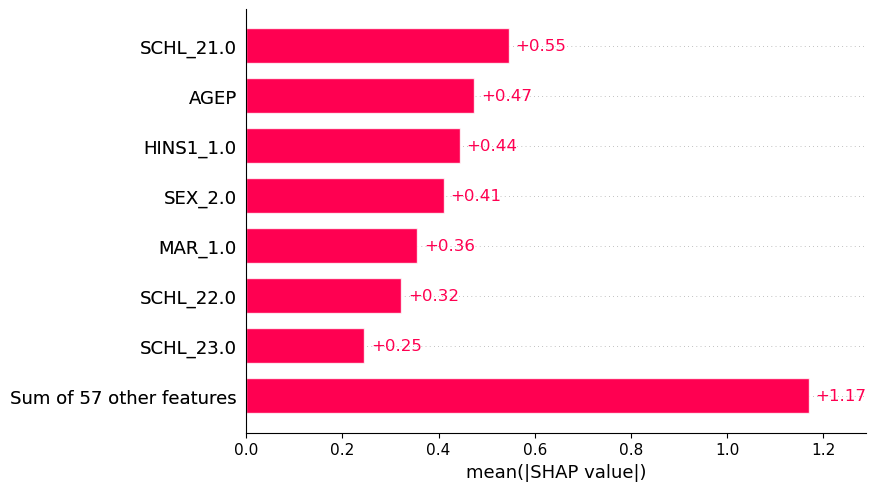

Generating general beeswarm plot...


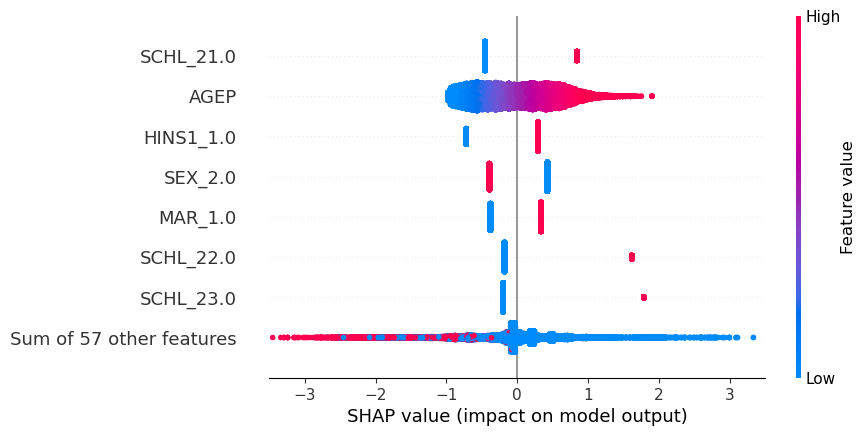

Generating row specific plots... - UNUSED
Row 0


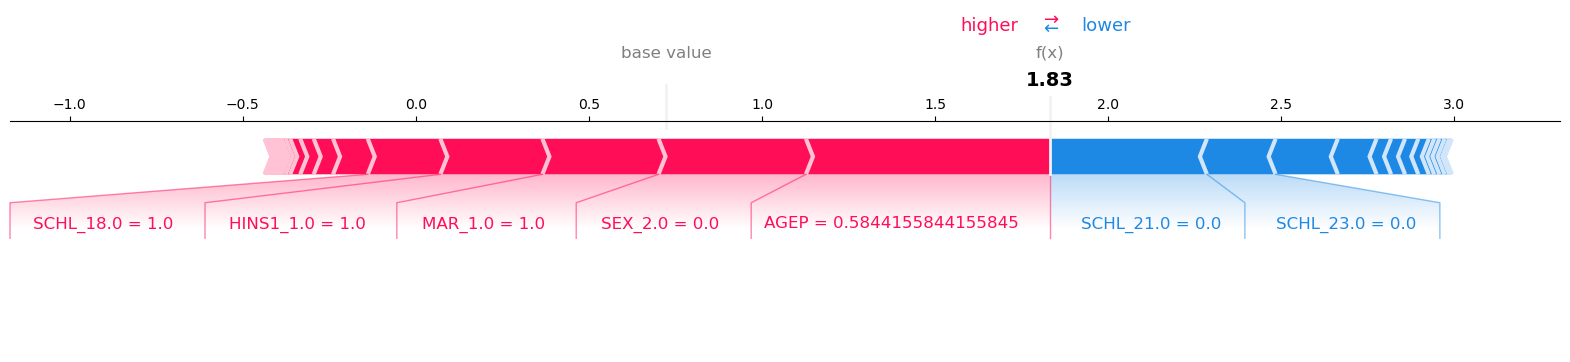

Row 1


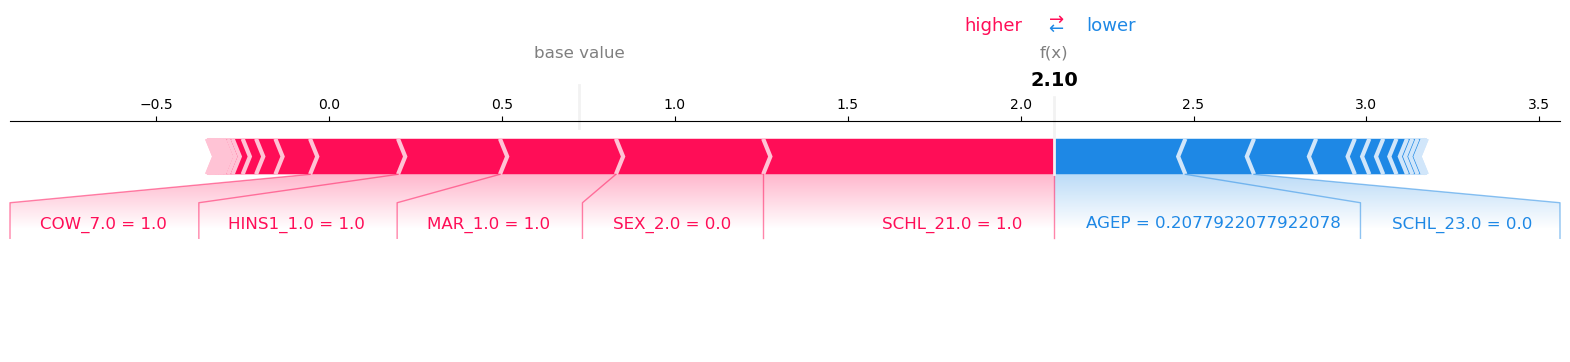

Row 2


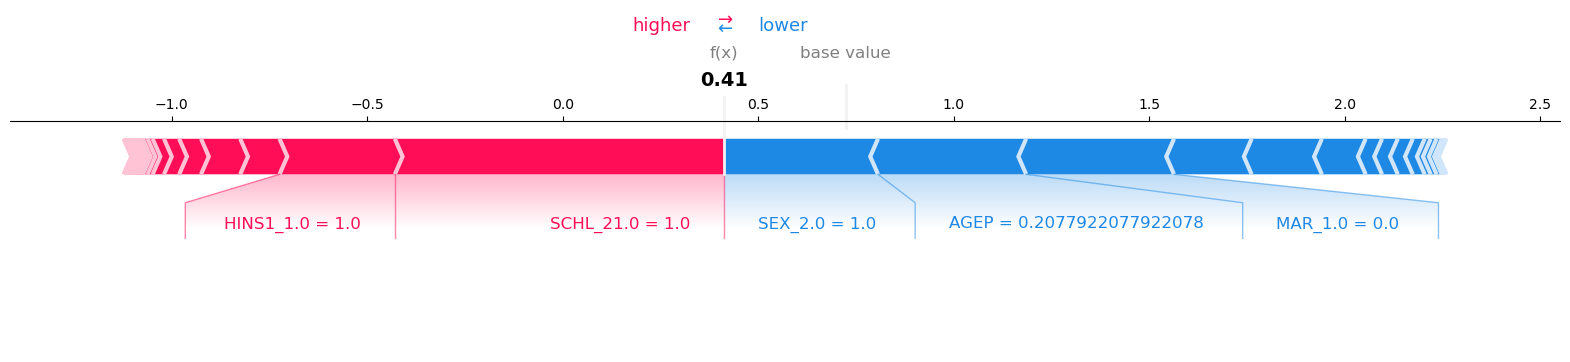

Row 3


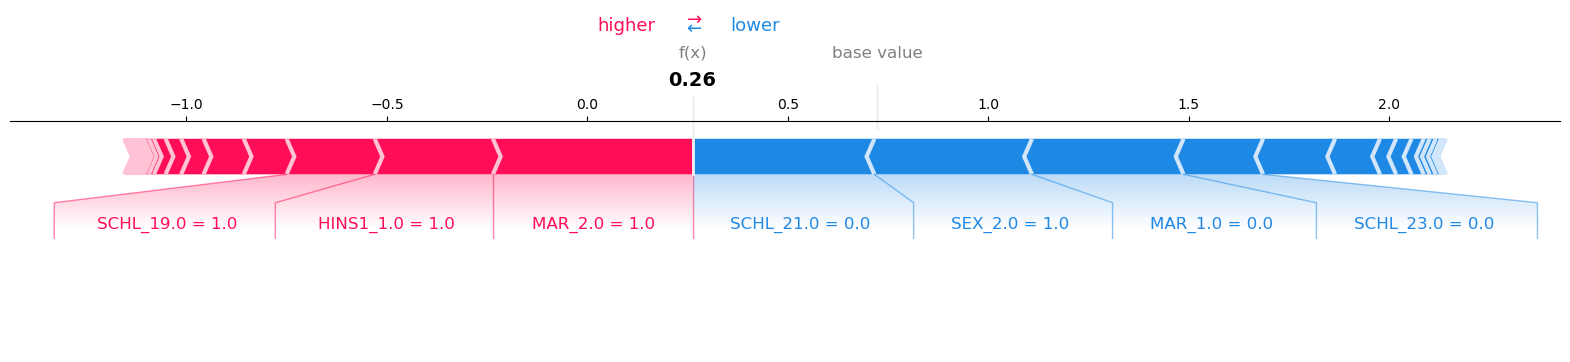

Row 4


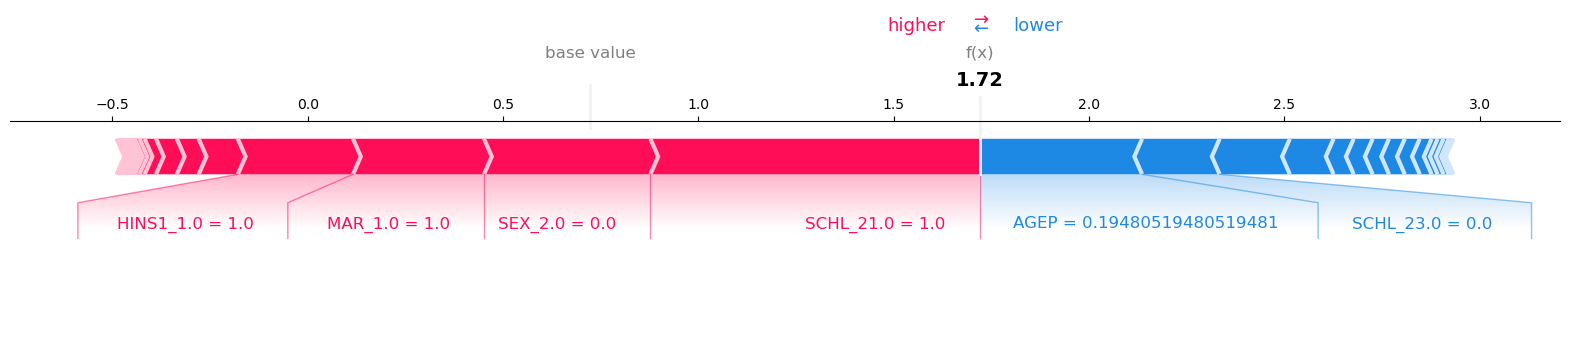

In [204]:
print('Calculating SHAP values...')
X_train_ = X_train.to_numpy().astype(float)
X_test_ = X_test.to_numpy().astype(float)
lr_explainer = shap.Explainer(
    p2,
    X_train_,
    # model_output='probability',
    # link=shap.links.logit,
    # algorithm='linear',
    feature_names=X_train.columns
    )

lr_shap_values = lr_explainer(X_test_)

print('Generating general bar plot...')
shap.plots.bar(lr_shap_values, max_display=8)

print('Generating general beeswarm plot...')
shap.plots.beeswarm(lr_shap_values, max_display=8, show=False)
ax = plt.gca()
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-3.5, 3.5) 
plt.show()

print('Generating row specific plots... - UNUSED')
for i in specific_rows:
    print(f'Row {i}')
    # shap.force_plot(shap_values[i], link='logit', matplotlib=True)
    shap.force_plot(lr_shap_values[i], matplotlib=True)

In [225]:
group_idx = list()
shap_agg_full = np.zeros((lr_shap_values.shape[0], len(X_train.columns)))
for i in feature_names:
    group_idx.append([n for n, l in enumerate(X_train.columns) if l.startswith(i)])

# group_idx now contains the indices of the features that belong to each group
# we can now sum the SHAP values for each group
    
for ii, g in enumerate(group_idx):
    print(np.sum(lr_shap_values[:, g].values, -1))
    print(shap_agg_full[:, ii])
    shap_agg_full[:, ii] = np.sum(lr_shap_values[:, g].values, -1)

# copy and replace? - YES
lr_shap_values_copy = lr_shap_values
lr_shap_values_copy.values = shap_agg_full

# now can do the force plots again
print('Generating row specific plots with aggregated categories...')
for i in specific_rows:
    print(f'Row {i}')
    # shap.force_plot(shap_values[i], link='logit', matplotlib=True)
    shap.force_plot(lr_shap_values_copy[i], feature_names=feature_names, matplotlib=True)

[ 0.70460006 -0.37882527 -0.37882527 ...  0.81667855  0.74195956
  0.40572411]
[0. 0. 0. ... 0. 0. 0.]
[ 0.53141186  0.53141186 -0.17210033 ...  0.4950741  -0.17210033
 -0.45947202]
[0. 0. 0. ... 0. 0. 0.]


KeyboardInterrupt: 

### Random Forest Plots

In [46]:
print('Calculating SHAP values...')
X_train_ = X_train.to_numpy().astype(float)
X_test_ = X_test.to_numpy().astype(float)
rf_explainer = shap.Explainer(p1, X_train_, model_output='probability', feature_names=X_train.columns)
rf_shap_values = rf_explainer(X_test_)

Calculating SHAP values...


100%|===================| 78169/78266 [13:34<00:01]        

Generating general bar plot...


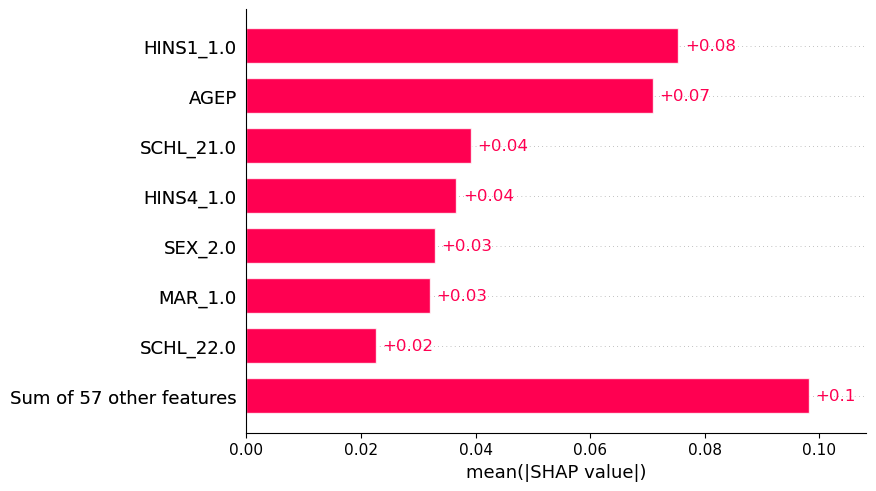

In [148]:
print('Generating general bar plot...')
shap.plots.bar(rf_shap_values[:,:,1], max_display=8)

Generating general beeswarm plot...


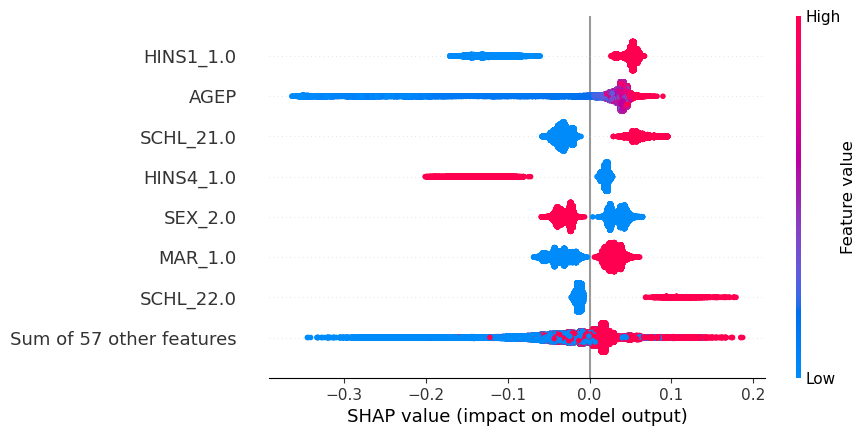

In [206]:
print('Generating general beeswarm plot...')
shap.plots.beeswarm(rf_shap_values[:,:,1], max_display=8)

# scaling:
# ax = plt.gca()
# # You can change the min and max value of xaxis by changing the arguments of:
# ax.set_xlim(-3.5, 3.5) 
# plt.show()

Generating row specific plots...
Row 0


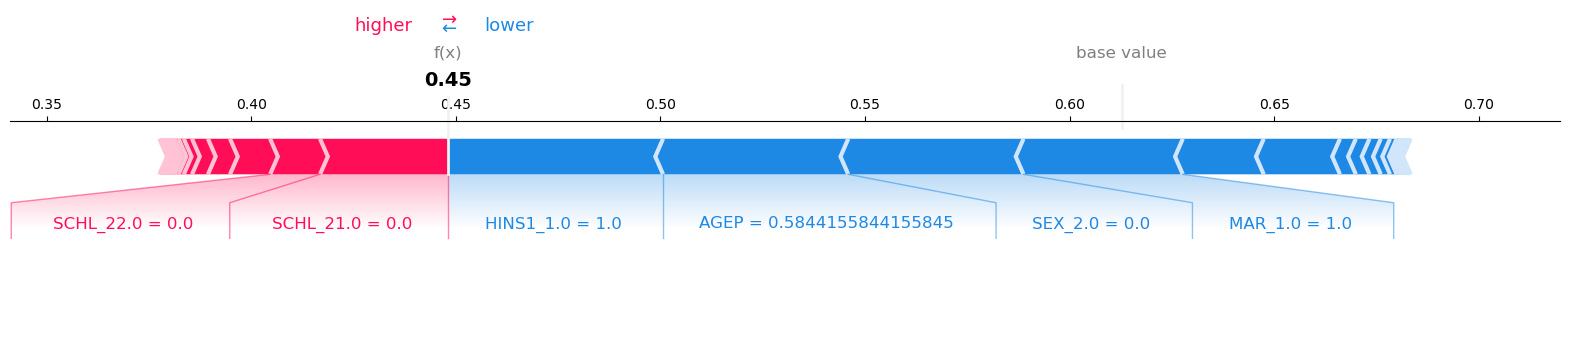

Row 1


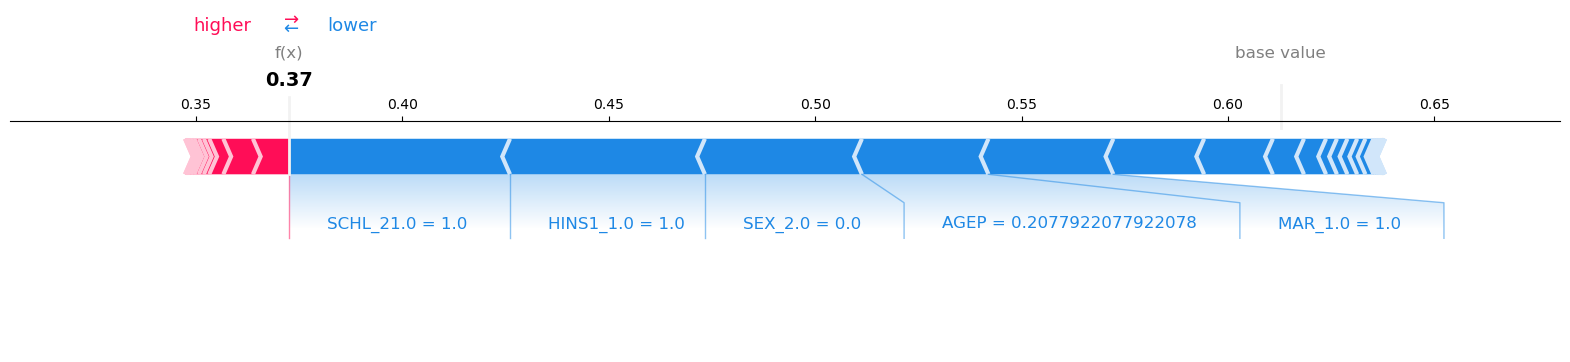

Row 2


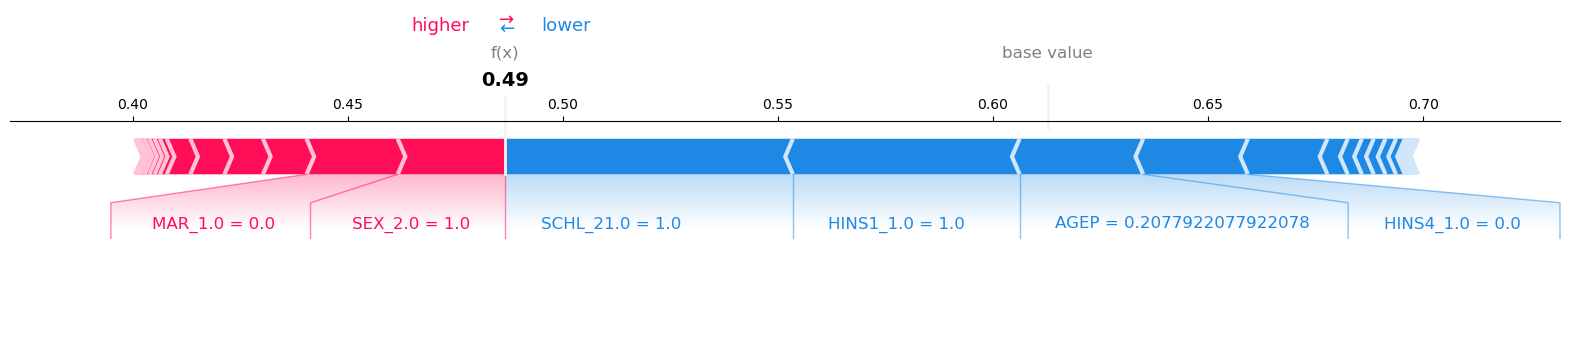

Row 3


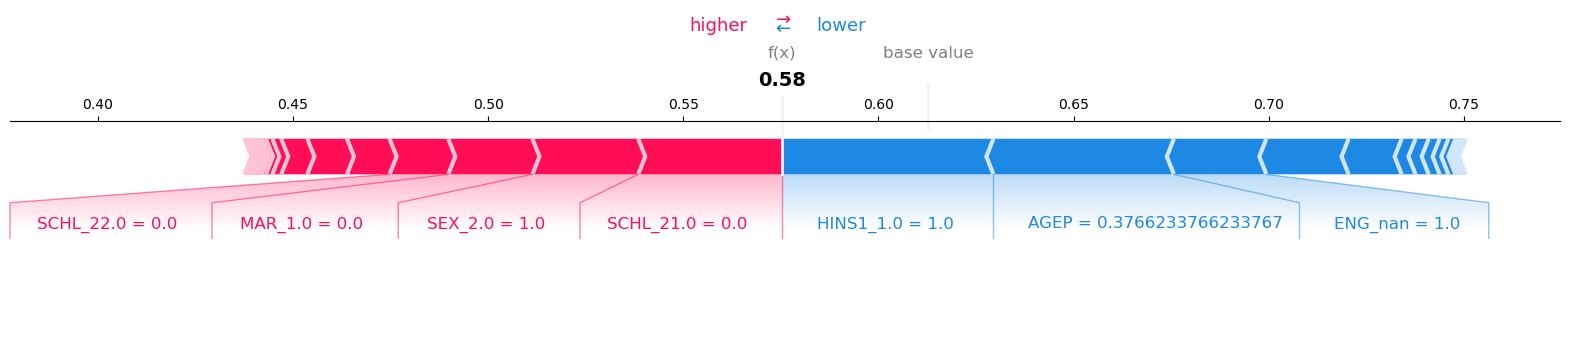

Row 4


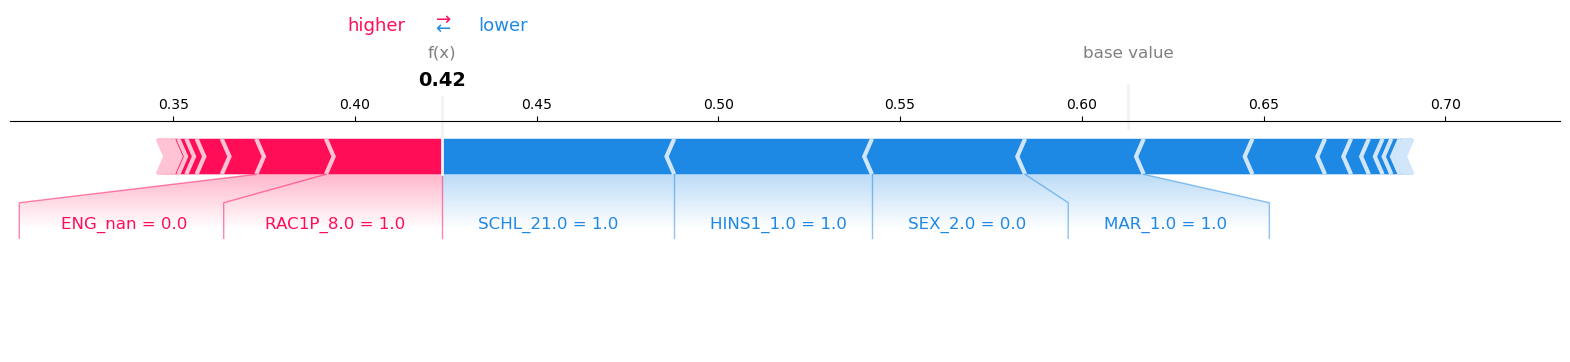

In [155]:
print('Generating row specific plots...')
for i in specific_rows:
    print(f'Row {i}')
    row_to_explain = X_test_[i]
    row_shap_values = rf_explainer(row_to_explain)
    shap.plots.force(rf_explainer.expected_value[1], row_shap_values.values[:,0], row_to_explain, feature_names=X_train.columns, matplotlib=True)

In [222]:
print(np.sum(rf_shap_values[:, g].values, -1).shape)
print(shap_agg_full[:, 0].shape)
print(shap_agg_full[:, 0])

(39133, 1)
(39133,)
[0. 0. 0. ... 0. 0. 0.]


In [226]:
# aggregating the SHAP values
group_idx = list()
shap_agg_full = np.zeros((rf_shap_values.shape[0], len(X_train.columns)))
for i in feature_names:
    group_idx.append([n for n, l in enumerate(X_train.columns) if l.startswith(i)])

# group_idx now contains the indices of the features that belong to each group
# we can now sum the SHAP values for each group
    
for ii, g in enumerate(group_idx):
    # maybe unpack below list of lists to just be a list?
    print(np.sum(rf_shap_values[:, g].values, -1))
    print(shap_agg_full[:, ii])
    shap_agg_full[:, ii] = np.sum(rf_shap_values[:, g].values, -1)

error

# copy and replace? - YES
lr_shap_values_copy = lr_shap_values
lr_shap_values_copy.values = shap_agg_full

# now can do the force plots again
print('Generating row specific plots with aggregated categories...')
for i in specific_rows:
    print(f'Row {i}')
    # shap.force_plot(shap_values[i], link='logit', matplotlib=True)
    shap.force_plot(lr_shap_values_copy[i], feature_names=feature_names, matplotlib=True)

[[ 7.33962197e-12]
 [ 8.93260223e-11]
 [-5.49607651e-10]
 ...
 [-3.10883479e-10]
 [ 2.94421626e-10]
 [-3.27800079e-10]]
[0. 0. 0. ... 0. 0. 0.]


ValueError: could not broadcast input array from shape (39133,1) into shape (39133,)